In [409]:
# import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import normaltest
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle
import warnings
warnings.filterwarnings('ignore')

## **CAPSTONE PROJECT 3 : MACHINE LEARNING FOR PREDICTING CALIFORNIA HOUSING PRICE**

Dataset dari California Housing Price bisa dilihat pada link [berikut](https://drive.google.com/drive/folders/1THcx8p2yRR1S6lJ56mbgU0qKPWPBDh9i?usp=drive_link) .

### **Contents**

1. Business Problem Understanding
2. Data Understanding
3. Explanatory Data Analysis
4. Modeling
    - 4.1. Modeling Menggunakan Outliers
    - 4.2. Modeling Tanpa Menggunakan Outliers
5. Hyperparameter Tuning
6. Predict to Test Set
7. Membuat Model untuk Tahun 2022
8. Final Model
9. Cost Evaluation
10. Model Limitation
11. Conclusion
12. Recommendation
13. Save & Load Model

****

### **1. BUSINESS PROBLEM UNDERSTANDING**

**Context**

Mengetahui harga wajar dari properti di suatu daerah adalah aspek yang penting dalam kehidupan, baik untuk investor maupun orang awam wajib untuk mengetahui harga wajar dari properti di suatu daerah agar terhindar dari pembelian properti yang merugikan.

Dalam setiap kondisi ekonomi, sektor properti selalu bisa bertahan bahkan terus mencatatkan peningkatan harganya. Beberapa penyebab kenaikkan harga properti pada setiap tahunnya adalah sebagaimana berikut :

- Inflasi
- Penawaran dan Permintaan (Supply & Demand)
- Ketersediaan Lahan
- Perkembangan Infrastruktur
- Harga Bahan Bangunan

Dari ke 5 aspek diatas, yang paling mempengaruhi perubahan harga properti pada setiap tahun nya adalah inflasi. Apabila kita bisa mendapatkan data rata-rata inflasi pada setiap tahun nya maka kita dapat mengetahui harga properti di suatu tahun dari perhitungan perubahan harga suatu properti. apabila kita bisa mendapatkan harga suatu properti di suatu tahun, maka kita bisa melakukan prediksi harga wajar suatu properti  di tahun tersebut berdasarkan beberapa fitur yang ada.

**Problem Statement**

Data California Housing Price berisikan hasil sensus mengenai median harga rumah dari perumahan di California pada tahun 1990. Data tersebut apabila digunakan untuk predictive analysis dapat menghasilkan output yang dapat membantu warga USA dalam menetapkan harga yang tepat ketika ingin membeli rumah di California.

**Goals**

Sebagai salah satu komitmen untuk menjalankan pemerintahan yang baik, Pemerintah USA akan menggunakan Data California Housing Price untuk mendapatkan model untuk memprediksi harga rumah di California pada tahun 2022. model ini nantinya akan di implementasikan menjadi aplikasi penentuan harga wajar dari rumah di California yang dapat digunakan oleh warga USA secara umum, dan secara bertahap kedepannya bisa dikembangkan hingga tidak hanya untuk memprediksi harga rumah di California, namun juga di USA secara menyeluruh.


**Analytic Approach**

Sebenarnya model tidak hanya bisa digunakan untuk memprediksi harga rumah di California pada tahun 1990, namun juga bisa digunakan untuk tahun yang lain, sebagai contoh apabila ingin memprediksi harga rumah di California pada tahun 2022, yang perlu dilakukan adalah mendapatkan harga rumah di California tahun tertentu dan besar inflation rates dari tahun tersebut hingga ke tahun 2022. Dari Data California Housing Price didapatkan median harga rumah dari perumahan di California pada tahun 1990, sedangkan Data Historis dari inflation rates di USA dapat didapatkan pada link [berikut](https://www.worlddata.info/america/usa/inflation-rates.php#:~:text=During%20the%20observation%20period%20from,year%20inflation%20rate%20was%203.0%25.) .

Dari data historis inflation rates didapatkan nilai rata-rata dari inflation rates adalah sebesar 2.64 % (perhitungan dilampirkan di cell berikutnya). kemudian rumus dari future value adalah sebagaimana berikut :

Future Value = Jumlah Uang x (1 + (Inflasi x Jumlah Tahun))

Sehingga didapatkan median harga rumah aktual di California pada tahun 2022 adalah sebagaimana berikut :

(median harga rumah di California pada tahun 1990) + (median harga rumah di California pada tahun 1990) x (2.64/100) x (2022-1990)

atau bisa disederhanakan menjadi :

(median harga rumah di California pada tahun 1990) + (median harga rumah di California pada tahun 1990) x 84.48/100

dan median pendapatan dari penghuni rumah di California pada tahun 2022 adalah sebagaimana berikut :

(median pendapatan dari penghuni rumah di California pada tahun 1990) + (median pendapatan dari penghuni rumah di California pada tahun 1990) x (2.64/100) x (2022-1990)

atau bisa disederhanakan menjadi :

(median pendapatan dari penghuni rumah di California pada tahun 1990) + (median pendapatan dari penghuni rumah di California pada tahun 1990) x 84.48/100

Selain itu bisa didapatkan perubahan median umur perumahan sebagaimana berikut :

(median umur perumahan di California pada tahun 1990) + (2022-1990)

atau bisa disederhanakan menjadi :

(median umur perumahan di California pada tahun 1990) + 32

Terlihat bahwa yang berubah dari data hanyalah pada kolom target dan 2 kolom pada features, sehingga model yang dibuat nantinya seharusnya bisa digunakan untuk memprediksi harga rumah di California pada tahun berapapun asalkan mendapatkan data historis inflation rates di USA.

In [292]:
# dataframe berisi data inflation rates
df_inflasi = pd.read_excel('inflasi.xlsx')
df_inflasi.head()

,Year,USA,EU,World
0,2022,0.0800,0.0883,0.0827
1,2021,0.0470,0.0255,0.0348
2,2020,0.0123,0.0048,0.0193
3,2019,0.0181,0.0163,0.0221
4,2018,0.0244,0.0174,0.0244


In [293]:
# Rata-rata inflation rates USA dari 1980 - 2022
df_inflasi['USA'].mean() * 100

2.647878787878788

**Metric Evaluation**

Evaluasi metrik yang akan digunakan adalah RMSE, MAE, dan MAPE, di mana RMSE adalah nilai rataan akar kuadrat dari error, MAE adalah rataan nilai absolut dari error, sedangkan MAPE adalah rataan persentase error yang dihasilkan oleh model regresi. Semakin kecil nilai RMSE, MAE, dan MAPE yang dihasilkan, berarti model semakin akurat dalam memprediksi harga perumahan sesuai dengan limitasi fitur yang digunakan. Pada pemodelan ini metrik akan lebih berfokus pada MAPE karena lebih mudah dipahami karena dalam skala persen. 

Selain itu, kita juga bisa menggunakan nilai R-squared atau adj. R-squared jika model yang nanti terpilih sebagai final model adalah model linear. Nilai R-squared digunakan untuk mengetahui seberapa baik model dapat merepresentasikan varians keseluruhan data. Semakin mendekati 1, maka semakin fit pula modelnya terhadap data observasi. Namun, metrik ini tidak valid untuk model non-linear.

### **2. DATA UNDERSTANDING**

- Dataset berisikan harga median rumah dari perumahan di California pada tahun 1990
- Setiap baris berisikan informasi rumah di California

In [294]:
df = pd.read_csv('data_california_house.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


**Informasi Kolom**

- longitude : koordinat garis bujur dari perumahan
- latitude : koordinat garis lintang dari perumahan
- housing_median_age : median umur rumah di perumahan tersebut
- total_rooms : banyaknya kamar
- total_bedrooms : banyaknya kamar tidur
- population : banyaknya populasi di perumahan tersebut
- households : banyaknya rumah tangga di perumahan tersebut
- median_income : median pendapatan dari penghuni di perumahan tersebut
- ocean_proximity : Lokasi perumahan terhadap laut, terbagi menjadi 5 kategori :
    1. INLAND :
        di daratan
    2. NEAR BAY :
        di dekat teluk
    3. <1H OCEAN :
        kurang 1 jam dari laut
    4. NEAR OCEAN :
        di dekat laut
    5. ISLAND :
        di pulau
- median_house_value : median harga rumah di perumahan tersebut

### **3. EXPLANATORY DATA ANALYSIS**

**Handle Missing Values**

In [295]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        137
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

<Axes: xlabel='total_bedrooms', ylabel='Count'>

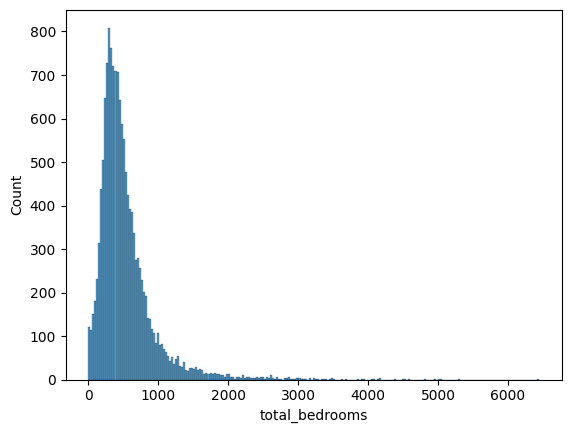

In [296]:
sns.histplot(df['total_bedrooms'])

In [297]:
stat, pvalue = normaltest(df['total_bedrooms'].dropna())
pvalue

if pvalue > 0.05 :
    print(f"pvalue = {pvalue:.5f}. pvalue > 0.05. Fail to reject Ho. Kita dapat mengasumsikan bahwa data terdistribusi Normal")
else:
    print(f"pvalue = {pvalue:.5f}. pvalue < 0.05. Reject Ho. Kita dapat mengasumsikan bahwa data TIDAK terdistribusi Normal")

pvalue = 0.00000. pvalue < 0.05. Reject Ho. Kita dapat mengasumsikan bahwa data TIDAK terdistribusi Normal


Terdapat missing values di kolom total_bedrooms, dan dikarenakan dari plot histogram dan hasil normal test terlihat kolom total_bedrooms tidak terdistribusi normal, maka kita akan menginputkan missing values pada kolom total_bedrooms dengan nilai median nya.

In [298]:
# define imputer
imp_median = SimpleImputer(strategy='median')

# fitting 
imp_median.fit(df[['total_bedrooms']])

# transform
df['total_bedrooms'] = imp_median.transform(df[['total_bedrooms']])

In [299]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
ocean_proximity       0
median_house_value    0
dtype: int64

Terlihat sudah tidak terdapat missing values pada semua kolom.

**Handle Duplicate**

In [300]:
df.duplicated().sum()

0

Tidak terdapat duplikat pada semua baris.

**Distribusi Kolom-Kolom Numerikal**

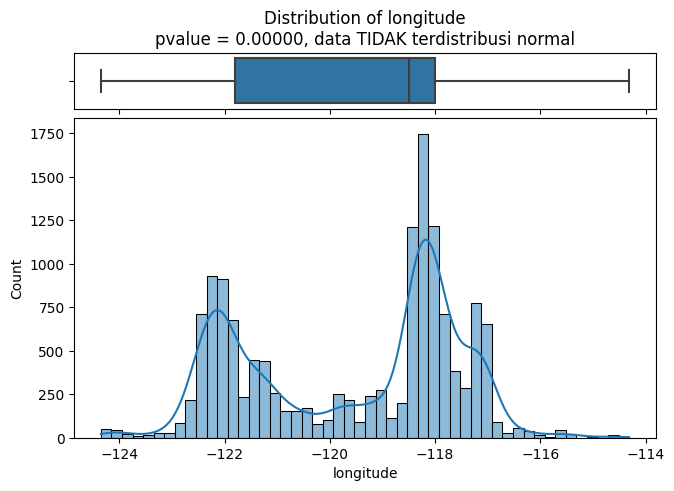

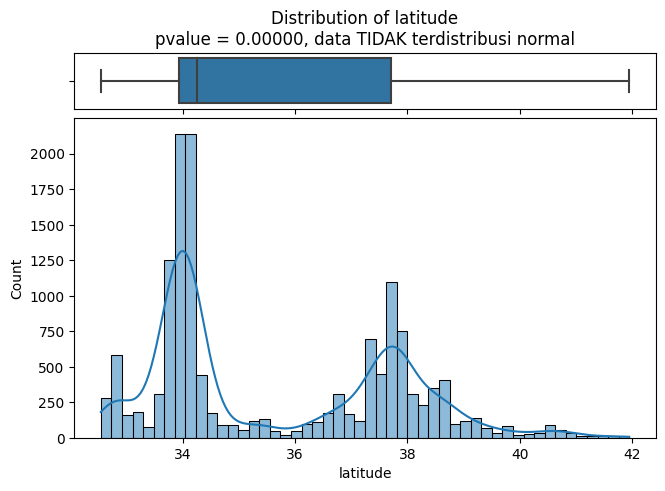

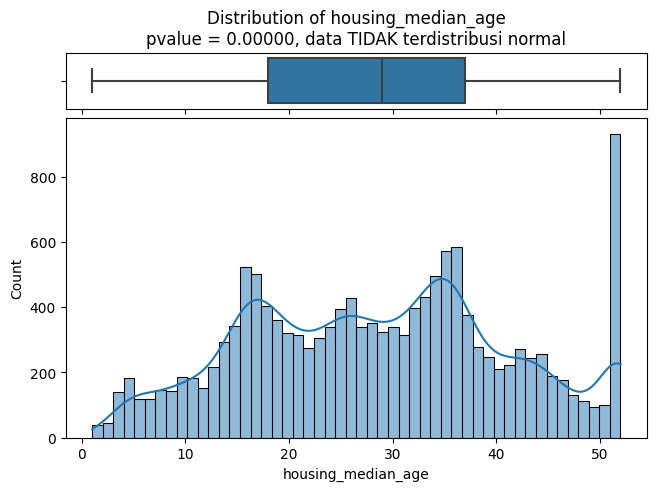

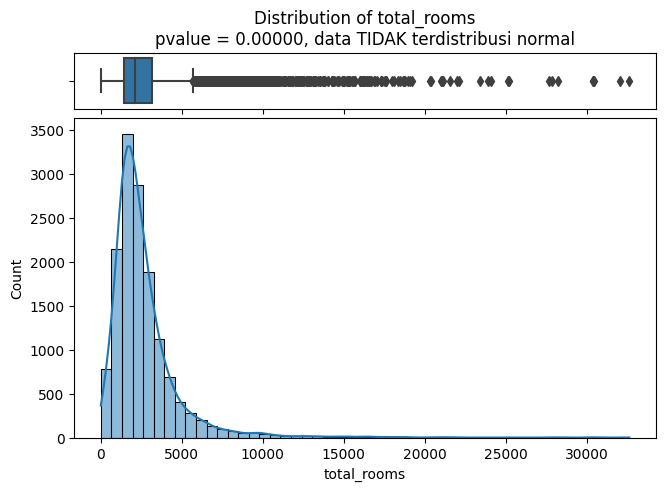

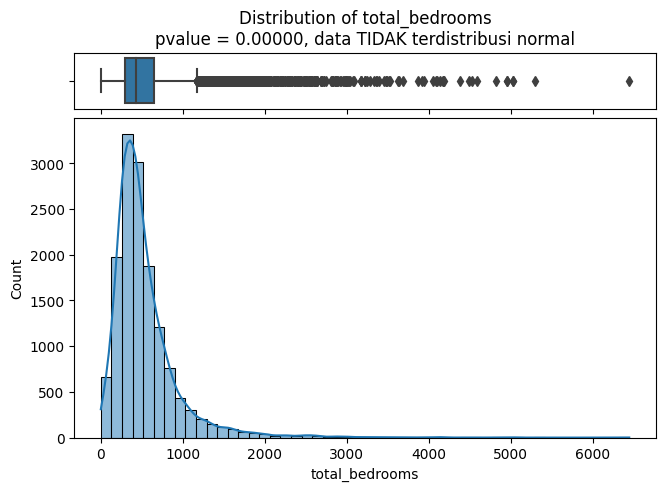

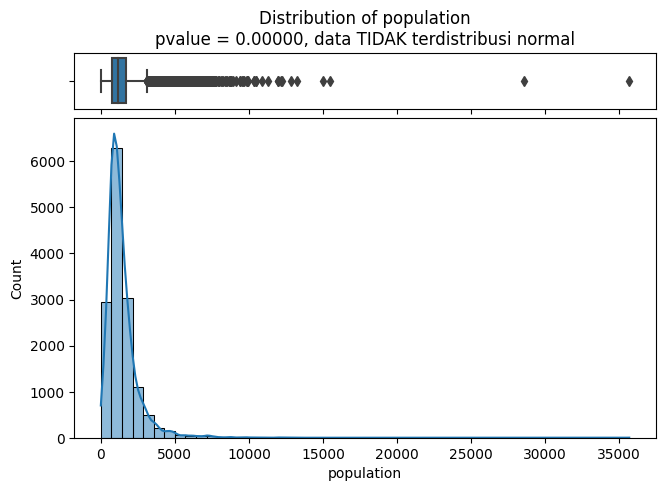

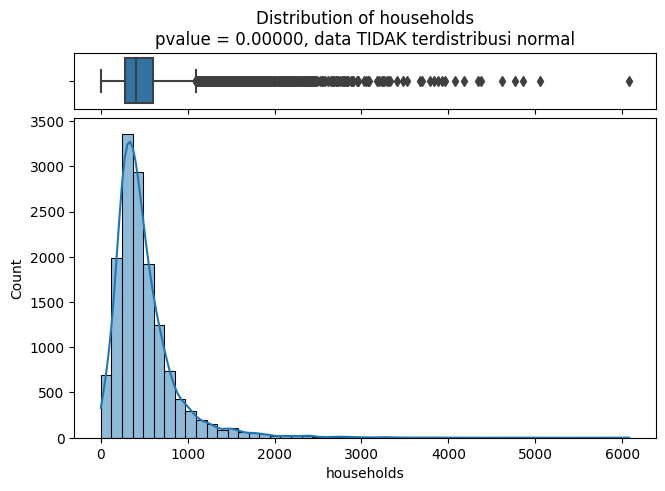

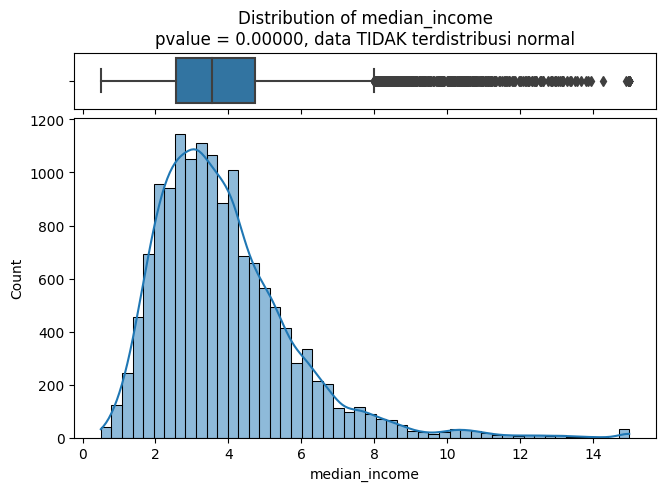

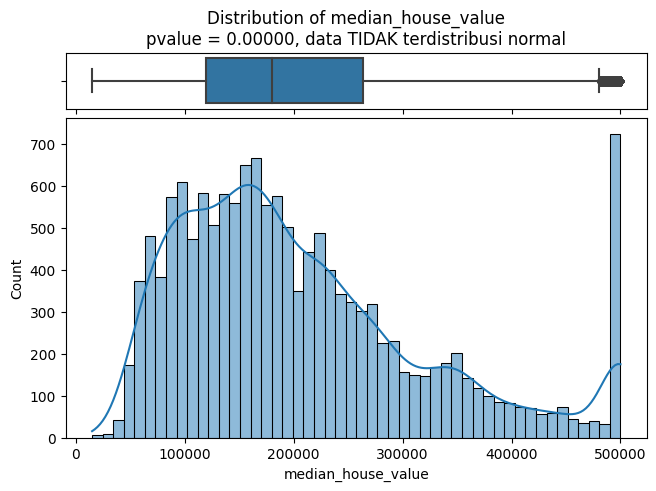

In [301]:
listKolom = ['longitude', 'latitude', 'housing_median_age', 'total_rooms' ,'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
for kolom in listKolom:

    fig, (ax1, ax2) = plt.subplots(2, sharex = True, figsize = (7.5,5), 
                                    gridspec_kw={"height_ratios": (.15, .85),
                                                "hspace": 0.05})

    stat, pvalue = normaltest(df[kolom])

    if pvalue > 0.05 :
        distribusi = f'pvalue = {pvalue:.5f}, data terdistribusi normal'
    else :
        distribusi = f'pvalue = {pvalue:.5f}, data TIDAK terdistribusi normal'

    ax1.set_title(f"Distribution of {kolom}\n{distribusi}", color = "black")
    sns.boxplot(x = df[kolom], ax = ax1)
    ax1.set(xlabel = "")

    sns.histplot(data = df[kolom], ax = ax2, kde=True, bins=50)

    plt.show()

Dari plot terlihat bahwa keseluruhan kolom numerikal tidak ada yang terdistribusi normal, sedangkan kolom-kolom numerikal yang memiliki outliers adalah kolom 'total_rooms' ,'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value'. Namun karena kolom 'median_house_value' adalah target, sehingga kolom tersebut tidak akan dilakukan handling outliers.

**Plot Tabel Korelasi Kolom-Kolom Numerikal**

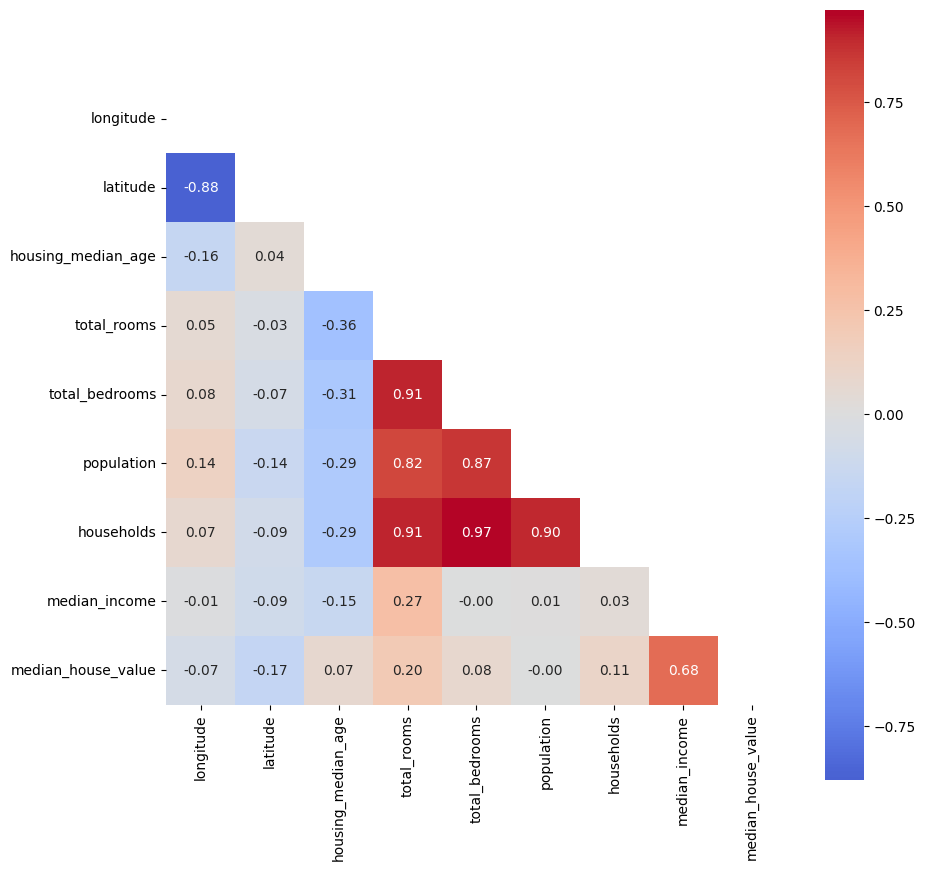

In [302]:
numerical_features = df.describe().columns

plt.figure(figsize=(10,10))

matrix = np.triu(df[numerical_features].corr(method='spearman'))

sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm', center=0, mask = matrix, square='True')
plt.show()

Terlihat masih banyak numerical features yang berkorelasi kuat, hal ini nantinya perlu di handle untuk menyelesaikan permasalahan multicollinearity.

### **4. MODELING**

In [303]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0
...,...,...,...,...,...,...,...,...,...,...
14443,-121.26,38.27,20.0,1314.0,229.0,712.0,219.0,4.4125,INLAND,144600.0
14444,-120.89,37.48,27.0,1118.0,195.0,647.0,209.0,2.9135,INLAND,159400.0
14445,-121.90,36.58,31.0,1431.0,435.0,704.0,393.0,3.1977,NEAR OCEAN,289300.0
14446,-117.93,33.62,34.0,2125.0,498.0,1052.0,468.0,5.6315,<1H OCEAN,484600.0


In [304]:
# features
X = df.drop(columns='median_house_value')

# target
y = df['median_house_value']

# create dummy variables (encoding)
X = pd.get_dummies(data=X, columns=['ocean_proximity'], drop_first=True)
X['ocean_proximity_INLAND'] = np.where(X['ocean_proximity_INLAND']==True, 1, 0)
X['ocean_proximity_ISLAND'] = np.where(X['ocean_proximity_ISLAND']==True, 1, 0)
X['ocean_proximity_NEAR BAY'] = np.where(X['ocean_proximity_NEAR BAY']==True, 1, 0)
X['ocean_proximity_NEAR OCEAN'] = np.where(X['ocean_proximity_NEAR OCEAN']==True, 1, 0)

**Cek Asumsi Untuk Model Multiple Linear Regression**

In [305]:
# Define Features
Xlinreg = sm.add_constant(X) # add constant to feature (intercept)
ylinreg = y # target

1. Multicollinearity

- Multicollinearity pada setiap kolom dapat dilihat dari nilai VIF (Variance Inflation Factor) nya
- VIF > 10 --> multicollinearity parah 
- VIF > 4 --> terindikasi multicollinearity

In [306]:
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['vif'] = [variance_inflation_factor(X.values, kolom) for kolom in range(len(X.columns))]
    vif = vif.sort_values('vif', ascending=False)
    
    return vif

In [307]:
calculate_vif(Xlinreg.drop(columns=['const']))

,feature,vif
0,longitude,831.399782
1,latitude,806.006683
6,households,77.789732
4,total_bedrooms,75.637356
3,total_rooms,31.102216
5,population,15.687355
7,median_income,8.999504
2,housing_median_age,8.134437
8,ocean_proximity_INLAND,2.717000
10,ocean_proximity_NEAR BAY,1.679533


In [308]:
calculate_vif(Xlinreg.drop(columns=['const', 'longitude']))

,feature,vif
5,households,77.552668
3,total_bedrooms,74.331587
2,total_rooms,30.385368
0,latitude,24.859833
4,population,15.394242
6,median_income,8.549189
1,housing_median_age,7.828803
7,ocean_proximity_INLAND,2.352808
9,ocean_proximity_NEAR BAY,1.367610
10,ocean_proximity_NEAR OCEAN,1.311129


In [309]:
calculate_vif(Xlinreg.drop(columns=['const', 'longitude', 'households']))

,feature,vif
2,total_rooms,30.364194
3,total_bedrooms,30.342169
0,latitude,24.840820
4,population,11.723177
5,median_income,8.542339
1,housing_median_age,7.827490
6,ocean_proximity_INLAND,2.323240
8,ocean_proximity_NEAR BAY,1.364875
9,ocean_proximity_NEAR OCEAN,1.310953
7,ocean_proximity_ISLAND,1.000556


In [310]:
calculate_vif(Xlinreg.drop(columns=['const', 'longitude', 'households', 'total_rooms']))

,feature,vif
0,latitude,22.387983
2,total_bedrooms,11.354326
3,population,10.748302
1,housing_median_age,7.769914
4,median_income,5.622208
5,ocean_proximity_INLAND,2.147075
7,ocean_proximity_NEAR BAY,1.351640
8,ocean_proximity_NEAR OCEAN,1.306614
6,ocean_proximity_ISLAND,1.000551


In [311]:
calculate_vif(Xlinreg.drop(columns=['const', 'longitude', 'households', 'total_rooms', 'latitude']))

,feature,vif
1,total_bedrooms,10.973079
2,population,10.680802
3,median_income,3.453436
0,housing_median_age,3.366408
4,ocean_proximity_INLAND,1.468628
6,ocean_proximity_NEAR BAY,1.331416
7,ocean_proximity_NEAR OCEAN,1.262615
5,ocean_proximity_ISLAND,1.000539


In [312]:
calculate_vif(Xlinreg.drop(columns=['const', 'longitude', 'households', 'total_rooms', 'latitude', 'total_bedrooms']))

,feature,vif
2,median_income,3.420526
0,housing_median_age,3.362558
1,population,2.107380
3,ocean_proximity_INLAND,1.442770
5,ocean_proximity_NEAR BAY,1.311263
6,ocean_proximity_NEAR OCEAN,1.248738
4,ocean_proximity_ISLAND,1.000470


Sekarang sudah tidak ada multicollinearity.

Multicollinearity terpenuhi apabila kita menghilangkan kolom 'longitude', 'households', 'total_rooms', 'latitude', dan 'total_bedrooms'.

2. Cek Normalitas Residu

In [313]:
# define model
model = sm.OLS(ylinreg, Xlinreg)

# model fitting
result = model.fit()
result

In [314]:
df_result = pd.DataFrame({
    'y_actual' : ylinreg,
    'y_predict' : result.predict(Xlinreg),
    'residual' : result.resid
})

df_result.head()

,y_actual,y_predict,residual
0,47500.0,97932.627080,-50432.627080
1,100000.0,182304.309661,-82304.309661
2,285800.0,288610.324612,-2810.324612
3,175000.0,152898.806954,22101.193046
4,59200.0,108826.973864,-49626.973864


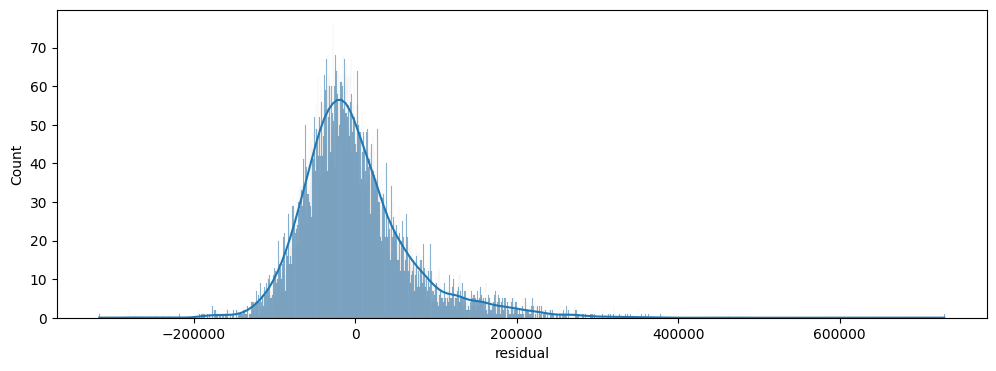

In [315]:
plt.figure(figsize=(12,4))
sns.histplot(data=df_result, x='residual', kde=True, binwidth=500)
plt.show()

In [316]:
stat, pvalue = normaltest(df_result['residual'])
pvalue

if pvalue > 0.05 :
    print(f"pvalue = {pvalue:.5f}. pvalue > 0.05. Fail to reject Ho. Kita dapat mengasumsikan bahwa data terdistribusi Normal")
else:
    print(f"pvalue = {pvalue:.5f}. pvalue < 0.05. Reject Ho. Kita dapat mengasumsikan bahwa data TIDAK terdistribusi Normal")

pvalue = 0.00000. pvalue < 0.05. Reject Ho. Kita dapat mengasumsikan bahwa data TIDAK terdistribusi Normal


Dari plot histrogram dan juga hasil dari normal test terlihat bahwa residu tidak terdistribusi normal.

3. Cek Asumsi Gauss-Markov

- Rata-rata error (residual) = 0 (mendekati nol)
- Uncorellated error
- Homoscedasticity (constant variance of residual)

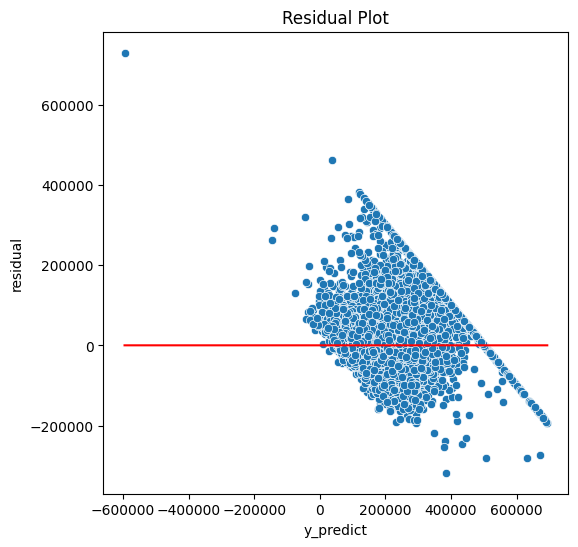

In [317]:
# Residual Plot
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_result, x='y_predict', y='residual')
sns.lineplot(data=df_result, x='y_predict', y=0, color='r')
plt.title('Residual Plot')
plt.show()

# Garis merah : garis bantu nilai 0

![](https://condor.depaul.edu/sjost/it223/documents/resid-plots.gif)

In [318]:
df_result['residual'].round(2).mean()

4.360465115505546e-05

1. Rata-rata error = 0
    - Terpenuhi, karena residual yang positif dan negatif jumlahnya sama
<br><br>
2. Uncorrelated error
    - Tidak terpenuhi, karena error membentuk pola tertentu (biased) --> linear negatif
<br><br>
3. Homoscedasticity
    - Terpenuhi, karena pada nilai prediksi harga yang kecil dan besar , variance errornya relatif seragam.

Meskipun rata-rata residu mendekati nilai 0, namun dari hasil plot residu terlihat cenderung mengikuti pola (b) biased and homoscedastic, agar memenuhi asumsi Gauss-Markov, plot harus cenderung mengikuti pola (a) unbiased and homoscedastic, jadi asumsi Gauss-Markov tidak terpenuhi.

Berdasarkan analisa di atas maka :

1. Multicollinearity terpenuhi setelah kita menghilangkan feature 'longitude', 'households', 'total_rooms', 'latitude', dan 'total_bedrooms'.
2. Normality assumption tidak terpenuhi (distribusi residu tidak normal)
3. Gauss-Markov assumption tidak terpenuhi (karena biased membentuk pola tertentu)

Karena hasil dari Normality assumption dan Gauss-Markov assumption tidak terpenuhi, maka pada pemodelan sebaiknya kita menggunakan model algoritma lain selain linear regression dan variasi nya (Ridge dan Lasso).

### **4.1 MODELING MENGGUNAKAN OUTLIERS**

**Data Splitting**

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Benchmark Model**

- KNN
- Decision Tree
- Random Forest
- Bagging KNN
- Bagging Decision Tree
- AdaBoost
- GradientBoost

In [320]:
# algoritma
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(random_state=0)
bag_knn = BaggingRegressor(random_state=0, base_estimator=knn)
bag_tree = BaggingRegressor(random_state=0, base_estimator=tree)
adaboost = AdaBoostRegressor(random_state=0)
gradboost = GradientBoostingRegressor(random_state=0)

In [321]:
# Scaler menggunakan Robust Scaler
scaler = RobustScaler()

# list algoritma model
models = [knn, tree, rf, bag_knn, bag_tree, adaboost, gradboost]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for algoritma in models:
    
    kfold = StratifiedKFold(n_splits=5)

    estimator1 = Pipeline([
        ('scaler', scaler),
        ('model', algoritma)
    ])

    estimator2 = Pipeline([
        ('model', algoritma)
    ])

    if algoritma in [knn, bag_knn] :
        estimator = estimator1
    else :
        estimator = estimator2

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, algoritma)

    score_rmse.append(abs(model_cv_rmse))
    nilai_mean_rmse.append(abs(model_cv_rmse.mean()))
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, algoritma)

    score_mae.append(abs(model_cv_mae))
    nilai_mean_mae.append(abs(model_cv_mae.mean()))
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=kfold, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, algoritma)

    score_mape.append(abs(model_cv_mape))
    nilai_mean_mape.append(abs(model_cv_mape.mean()))
    nilai_std_mape.append(model_cv_mape.std())

[-64058.05091917 -63244.60423395 -61472.74862666 -62460.69792736
 -62325.76242896] KNeighborsRegressor()
[-44235.82880623 -43214.42707612 -41492.31349481 -42548.51345738
 -42929.88195586] KNeighborsRegressor()
[-0.24811368 -0.23621992 -0.22659613 -0.23213781 -0.23545221] KNeighborsRegressor()
[-71266.30319913 -70851.24102388 -72834.4997056  -68744.93831517
 -72386.14329188] DecisionTreeRegressor(random_state=0)
[-46304.62889273 -45180.70458478 -46484.12932526 -44748.369537
 -45954.51882302] DecisionTreeRegressor(random_state=0)
[-0.25546392 -0.25855823 -0.24874211 -0.24112314 -0.25450614] DecisionTreeRegressor(random_state=0)
[-51226.01806837 -51826.636525   -49286.86475385 -51882.2368845
 -50466.79156601] RandomForestRegressor(random_state=0)
[-33656.01807526 -34023.39742647 -32545.99474048 -34220.5518174
 -33525.49954565] RandomForestRegressor(random_state=0)
[-0.19040092 -0.19073141 -0.17810469 -0.18598347 -0.19023519] RandomForestRegressor(random_state=0)
[-63083.39787255 -62383.78

In [322]:
# Hasil evaluasi
df_result_cv =pd.DataFrame({
    'Model': ['KNN', 'Decision Tree', 'Random Forest', 'Bagging KNN', 'Bagging Decision Tree', 'AdaBoost', 'GradientBoost'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape
})

df_result_cv.sort_values('Mean_RMSE',ascending=True)

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
2,Random Forest,50937.709560,970.824098,33594.292321,580.310689,0.187091,0.004818
4,Bagging Decision Tree,53703.968707,1130.402180,35451.372183,618.620220,0.197385,0.006667
6,GradientBoost,55434.556804,694.844653,38641.003722,332.678275,0.216715,0.004479
3,Bagging KNN,61974.448424,747.204141,42373.913357,768.368669,0.232801,0.006522
0,KNN,62712.372827,876.766310,42884.192958,893.092458,0.235704,0.007071
1,Decision Tree,71216.625107,1430.419522,45734.470233,665.513638,0.251679,0.006159
5,AdaBoost,86391.222231,5142.836302,73149.756216,6095.311871,0.490235,0.057787


Hasil modeling saat masih terdapat outliers menunjukkan model dengan menggunakan algoritma Random Forest menghasilkan nilai terbaik dimana rata-rata RMSE sebesar 50937, rata-rata MAE sebesar 33594 dan rata-rata MAPE sebesar 18% (hasil cross validation dengan jumlah splitting 5).

### **4.2 MODELING TANPA MENGGUNAKAN OUTLIERS**

**Handling Outliers**

In [323]:
kolom_outliers = ['total_rooms' ,'total_bedrooms', 'population', 'households', 'median_income']

In [324]:
# mencari nilai lower dan upper fence pada masing-masing kolom numerikal

list_lower = []
list_upper = []
number_lower = []
number_inside = []
number_upper = []
percentage_outlier = []

for feature in kolom_outliers: 
    IQR = df[feature].quantile(0.75) - df[feature].quantile(0.25)
    lower_fence = df[feature].quantile(0.25) - 1.5*IQR
    upper_fence = df[feature].quantile(0.75) + 1.5*IQR
    list_lower.append(lower_fence)
    list_upper.append(upper_fence)
    number_lower.append(len(df[df[feature]<lower_fence]))
    number_inside.append(len(df[(df[feature]>=lower_fence) & (df[feature]<=upper_fence)]))
    number_upper.append(len(df[df[feature]>upper_fence]))
    percentage_outlier.append(round((len(df[df[feature]<lower_fence]) + len(df[df[feature]>upper_fence])) / len(df)  *100, 2))

outliers = pd.DataFrame({
    'Kolom' : kolom_outliers,
    'Lower' : list_lower,
    'Upper' : list_upper,
    '# Lower' : number_lower,
    '# Inside' : number_inside,
    '# Upper' : number_upper,
    '% Outlier' : percentage_outlier
})

outliers

,Kolom,Lower,Upper,# Lower,# Inside,# Upper,% Outlier
0,total_rooms,-1094.50000,5693.50000,0,13548,900,6.23
1,total_bedrooms,-227.50000,1168.50000,0,13560,888,6.15
2,population,-626.00000,3134.00000,0,13621,827,5.72
3,households,-208.50000,1091.50000,0,13606,842,5.83
4,median_income,-0.67765,7.98435,0,13966,482,3.34


In [325]:
# menghapus outliers

df_without_outliers = df[(df['total_rooms']>=-1094.5) & (df['total_rooms']<=5693.5) & (df['total_bedrooms']>=-227.5) & (df['total_rooms']<=1168.5) & (df['population']>=-626) & (df['population']<=3134) & (df['households']>=-208.5) & (df['households']<=1091.5) & (df['median_income']>=-0.67765) & (df['median_income']<=7.98435)]
df_without_outliers

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0
21,-117.34,34.13,29.0,331.0,85.0,341.0,107.0,0.7069,INLAND,70300.0
24,-120.84,38.77,11.0,1013.0,188.0,410.0,158.0,4.8250,INLAND,184600.0
...,...,...,...,...,...,...,...,...,...,...
14426,-117.73,34.06,34.0,344.0,108.0,315.0,119.0,3.1786,INLAND,117800.0
14430,-119.01,35.38,44.0,434.0,110.0,274.0,86.0,1.1944,INLAND,57500.0
14434,-122.22,37.47,35.0,367.0,113.0,398.0,109.0,2.5000,NEAR OCEAN,166700.0
14442,-120.06,36.94,19.0,901.0,183.0,700.0,190.0,2.2375,INLAND,64300.0


In [326]:
# features
X_without_outliers = df_without_outliers.drop(columns='median_house_value')

# target
y_without_outliers = df_without_outliers['median_house_value']

# create dummy variables (encoding)
X_without_outliers = pd.get_dummies(data=X_without_outliers, columns=['ocean_proximity'], drop_first=True)
X_without_outliers['ocean_proximity_INLAND'] = np.where(X_without_outliers['ocean_proximity_INLAND']==True, 1, 0)
X_without_outliers['ocean_proximity_ISLAND'] = np.where(X_without_outliers['ocean_proximity_ISLAND']==True, 1, 0)
X_without_outliers['ocean_proximity_NEAR BAY'] = np.where(X_without_outliers['ocean_proximity_NEAR BAY']==True, 1, 0)
X_without_outliers['ocean_proximity_NEAR OCEAN'] = np.where(X_without_outliers['ocean_proximity_NEAR OCEAN']==True, 1, 0)

**Data Splitting**

In [327]:
X_train_without_outliers, X_test_without_outliers, y_train_without_outliers, y_test_without_outliers = train_test_split(X_without_outliers, y_without_outliers, test_size=0.2, random_state=0)

**Benchmark Model**

- KNN
- Decision Tree
- Random Forest
- Bagging KNN
- Bagging Decision Tree
- AdaBoost
- GradientBoost

In [328]:
# Scaler menggunakan Robust Scaler
scaler = RobustScaler()

# list algoritma model
models = [knn, tree, rf, bag_knn, bag_tree, adaboost, gradboost]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

# Mencari algoritma terbaik berdasarkan tiap metrics
for algoritma in models:
    
    kfold = StratifiedKFold(n_splits=5)

    estimator1 = Pipeline([
        ('scaler', scaler),
        ('model', algoritma)
    ])

    estimator2 = Pipeline([
        ('model', algoritma)
    ])

    if algoritma in [knn, bag_knn] :
        estimator = estimator1
    else :
        estimator = estimator2

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        X_train_without_outliers, 
        y_train_without_outliers, 
        cv=kfold, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, algoritma)

    score_rmse.append(abs(model_cv_rmse))
    nilai_mean_rmse.append(abs(model_cv_rmse.mean()))
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        X_train_without_outliers, 
        y_train_without_outliers, 
        cv=kfold, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, algoritma)

    score_mae.append(abs(model_cv_mae))
    nilai_mean_mae.append(abs(model_cv_mae.mean()))
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator, 
        X_train_without_outliers, 
        y_train_without_outliers, 
        cv=kfold, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, algoritma)

    score_mape.append(abs(model_cv_mape))
    nilai_mean_mape.append(abs(model_cv_mape.mean()))
    nilai_std_mape.append(model_cv_mape.std())

[-72762.76877616 -75791.84671345 -71665.09522814 -75219.4214808
 -72119.12411165] KNeighborsRegressor()
[-49071.89579832 -50379.85546218 -48684.34005602 -49948.59719888
 -49070.83697479] KNeighborsRegressor()
[-0.36504923 -0.34347448 -0.34047842 -0.32819609 -0.34889755] KNeighborsRegressor()
[ -85279.25750294  -96269.38923208 -101035.16993688  -95895.58214299
  -97820.67053431] DecisionTreeRegressor(random_state=0)
[-58196.38655462 -64875.66666667 -64544.84593838 -61528.88515406
 -64458.01120448] DecisionTreeRegressor(random_state=0)
[-0.42457507 -0.45499671 -0.4448077  -0.38894697 -0.43438553] DecisionTreeRegressor(random_state=0)
[-69570.99959648 -68379.56230566 -64941.08378042 -68561.28502565
 -66749.20676812] RandomForestRegressor(random_state=0)
[-44211.27406162 -45395.21448179 -43407.7570028  -44198.36677871
 -45510.99459384] RandomForestRegressor(random_state=0)
[-0.32776106 -0.32187045 -0.31045474 -0.30235507 -0.35794154] RandomForestRegressor(random_state=0)
[-72315.8256498  -

In [329]:
# Hasil evaluasi
df_result_cv_without_outliers =pd.DataFrame({
    'Model': ['KNN', 'Decision Tree', 'Random Forest', 'Bagging KNN', 'Bagging Decision Tree', 'AdaBoost', 'GradientBoost'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape
})

display(df_result_cv.sort_values('Mean_RMSE',ascending=True),df_result_cv_without_outliers.sort_values('Mean_RMSE',ascending=True))

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
2,Random Forest,50937.709560,970.824098,33594.292321,580.310689,0.187091,0.004818
4,Bagging Decision Tree,53703.968707,1130.402180,35451.372183,618.620220,0.197385,0.006667
6,GradientBoost,55434.556804,694.844653,38641.003722,332.678275,0.216715,0.004479
3,Bagging KNN,61974.448424,747.204141,42373.913357,768.368669,0.232801,0.006522
0,KNN,62712.372827,876.766310,42884.192958,893.092458,0.235704,0.007071
1,Decision Tree,71216.625107,1430.419522,45734.470233,665.513638,0.251679,0.006159
5,AdaBoost,86391.222231,5142.836302,73149.756216,6095.311871,0.490235,0.057787


,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
6,GradientBoost,66775.581685,1289.948543,44216.012827,1706.241180,0.322266,0.019536
2,Random Forest,67640.427495,1624.939283,44544.721384,797.603794,0.324077,0.019093
4,Bagging Decision Tree,71210.024077,1830.226281,47294.167339,1198.048222,0.346495,0.019309
3,Bagging KNN,71429.081853,1440.848284,48062.881378,673.982000,0.339625,0.017358
0,KNN,73511.651262,1674.843064,49431.105098,629.985365,0.345219,0.012017
5,AdaBoost,79750.584995,2683.972494,61223.862156,4027.515981,0.505973,0.054169
1,Decision Tree,95260.013870,5309.381762,62720.759104,2564.350784,0.429542,0.022703


Setelah dilakukan handling outlier menunjukkan hasil yang lebih buruk dimana nilai rata-rata RMSE naik dari 50937 ke 66775, sedangkan nilai rata-rata MAE naek dari 33594 ke 44216, begitu pula pada nilai rata-rata MAPE dari 18% naik menjadi 32%. Dari hasil tersebut, model terbaik yang akan digunakan tetap menggunakan random forest, dan dataset yang digunakan tetap dataset yang masih memiliki outliers.

### **5. HYPERPARAMETER TUNING**

**Tuning 1**

In [335]:
hyperparam_space={
    'n_estimators' : range(50,1000,50),
    'max_depth' : range(2,10,1),
    'min_samples_split' : range(50,1000,50),
    'min_samples_leaf' : range(50,1000,50),
    'max_features' : range(3,12,1)
}

random_search = RandomizedSearchCV(
    estimator= rf,
    param_distributions=hyperparam_space,
    cv=kfold,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    n_iter=500,
    n_jobs=-1,
    refit='neg_mean_absolute_percentage_error',
    random_state=0
)

In [336]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(random_state=0), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'max_features': range(3, 12),
                                        'min_samples_leaf': range(50, 1000, 50),
                                        'min_samples_split': range(50, 1000, 50),
                                        'n_estimators': range(50, 1000, 50)},
                   random_state=0, refit='neg_mean_absolute_percentage_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [338]:
abs(random_search.best_score_)

0.24698925106987651

In [342]:
random_search.best_params_

{'n_estimators': 900,
 'min_samples_split': 200,
 'min_samples_leaf': 50,
 'max_features': 7,
 'max_depth': 8}

In [341]:
dftop5 = pd.DataFrame(random_search.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()
dftop5

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
414,47.887404,1.467598,0.225829,0.016373,900,200,50,7,8,"{'n_estimators': 900, 'min_samples_split': 200...",...,426.351824,1,-0.248267,-0.248161,-0.240382,-0.246599,-0.251537,-0.246989,0.003674,1
205,14.119074,0.346077,0.104504,0.008171,400,100,100,5,9,"{'n_estimators': 400, 'min_samples_split': 100...",...,408.934854,3,-0.261357,-0.260892,-0.251785,-0.257161,-0.263567,-0.258952,0.004133,3
193,18.156893,0.684232,0.083527,0.005604,300,150,100,9,8,"{'n_estimators': 300, 'min_samples_split': 150...",...,425.772518,2,-0.252933,-0.252728,-0.243192,-0.251017,-0.257207,-0.251415,0.004590,2
358,16.980978,0.493677,0.067066,0.003933,300,450,50,9,9,"{'n_estimators': 300, 'min_samples_split': 450...",...,485.706260,5,-0.266183,-0.266912,-0.258341,-0.263890,-0.271313,-0.265328,0.004242,7
352,12.404331,0.535790,0.049482,0.007722,200,450,50,10,9,"{'n_estimators': 200, 'min_samples_split': 450...",...,504.947145,7,-0.265713,-0.266682,-0.257704,-0.263409,-0.270205,-0.264743,0.004144,6


Dari hasil hyperparameter tuning terlihat bahwa performa model berkurang (MAPE bertambah) setelah dilakukan tuning :
- MAPE sebelum tuning : 18%
- MAPE setelah tuning 1 : 24%

**Tuning 2**

- mempersempit rentang  nilai pada hyperparameter

In [343]:
hyperparam_space={
    'n_estimators' : range(800,1001,10),
    'max_depth' : range(8,12,1),
    'min_samples_split' : range(30,201,10),
    'min_samples_leaf' : range(30,201,10),
    'max_features' : range(4,11,1)
}

random_search = RandomizedSearchCV(
    estimator= rf,
    param_distributions=hyperparam_space,
    cv=kfold,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'],
    n_iter=500,
    n_jobs=-1,
    refit='neg_mean_absolute_percentage_error',
    random_state=0
)

In [344]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestRegressor(random_state=0), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'max_depth': range(8, 12),
                                        'max_features': range(4, 11),
                                        'min_samples_leaf': range(30, 201, 10),
                                        'min_samples_split': range(30, 201, 10),
                                        'n_estimators': range(800, 1001, 10)},
                   random_state=0, refit='neg_mean_absolute_percentage_error',
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error'])

In [345]:
abs(random_search.best_score_)

0.21696181842968926

In [346]:
random_search.best_params_

{'n_estimators': 970,
 'min_samples_split': 50,
 'min_samples_leaf': 30,
 'max_features': 9,
 'max_depth': 11}

Dari hasil hyperparameter tuning kedua terlihat bahwa performa model berkurang (MAPE bertambah) setelah dilakukan tuning namun tidak serendah saat tuning pertama :

- MAPE sebelum tuning : 18%
- MAPE setelah tuning 1 : 24%
- MAPE setelah tuning 2 : 21%

Hal tersebut menunjukkan model tidak perlu dilakukan hyperparameter tuning untuk menghasilkan model yang lebih baik.

### **6. PREDICT TO TEST SET**

**Sebelum Tuning**

In [353]:
# define model
model = rf

# fitting
model.fit(X_train, y_train)

# predict 
y_pred_rf = model.predict(X_test)

# evaluate
display(np.sqrt(mean_squared_error(y_test, y_pred_rf)), mean_absolute_error(y_test, y_pred_rf),mean_absolute_percentage_error(y_test, y_pred_rf))

50209.49036188093

33264.39193771627

0.18738913335165625

**Setelah Tuning**

In [347]:
random_search.best_estimator_

RandomForestRegressor(max_depth=11, max_features=9, min_samples_leaf=30,
                      min_samples_split=50, n_estimators=970, random_state=0)

In [357]:
# define model
model = random_search.best_estimator_

# fitting
model.fit(X_train, y_train)

# predict 
y_pred_rf_tuning = model.predict(X_test)

# evaluate (f1-score)
display(np.sqrt(mean_squared_error(y_test, y_pred_rf_tuning)), mean_absolute_error(y_test, y_pred_rf_tuning),mean_absolute_percentage_error(y_test, y_pred_rf_tuning))

57546.05844156339

39412.11012369418

0.2205861331712056

### **7. MEMBUAT MODEL UNTUK TAHUN 2022**

**Mengubah nilai target (median harga rumah/kolom median_house_value) berdasarkan perubahan inflasi**

In [366]:
y_tahun2022 = (y + (y * 84.48 / 100))
y_tahun2022

0         87628.00
1        184480.00
2        527243.84
3        322840.00
4        109212.16
           ...    
14443    266758.08
14444    294061.12
14445    533700.64
14446    893990.08
14447    128029.12
Name: median_house_value, Length: 14448, dtype: float64

**Mengubah nilai fitur median pendapatan penghuni (kolom median_income) berdasarkan perubahan inflasi**

In [378]:
X_tahun2022 = X
X_tahun2022['median_income'] = (X_tahun2022['median_income'] + (X_tahun2022['median_income'] * 84.48 / 100))

In [379]:
X_tahun2022['median_income']

0         3.643480
1         4.169986
2        11.620395
3         3.172872
4         4.096563
           ...    
14443     8.140180
14444     5.374825
14445     5.899117
14446    10.388991
14447     2.560951
Name: median_income, Length: 14448, dtype: float64

**Mengubah nilai fitur median umur perumahan (kolom housing_median_age) berdasarkan selisih tahun**

In [382]:
X_tahun2022['housing_median_age'] = (X_tahun2022['housing_median_age'] + 32)


In [383]:
X_tahun2022['housing_median_age']

0        94.0
1        85.0
2        59.0
3        59.0
4        92.0
         ... 
14443    62.0
14444    69.0
14445    73.0
14446    76.0
14447    57.0
Name: housing_median_age, Length: 14448, dtype: float64

**Data Splitting**

In [384]:
X_train2022, X_test2022, y_train2022, y_test2022 = train_test_split(X_tahun2022, y_tahun2022, test_size=0.2, random_state=0)

In [386]:
# define model
model = rf

# fitting
model.fit(X_train2022, y_train2022)

# predict 
y_pred_rf2022 = model.predict(X_test2022)

# evaluate
display(np.sqrt(mean_squared_error(y_test2022, y_pred_rf2022)), mean_absolute_error(y_test2022, y_pred_rf2022),mean_absolute_percentage_error(y_test2022, y_pred_rf2022))

92516.16249731882

61292.45726586021

0.1871102219758526

Ketika diprediksi ke test_set, model terbaik menghasilkan nilai rata-rata RMSE sebesar 92516, MAE sebesar 61292, dan rata-rata MAPE sebesar 18%. dimana nilai MAPE tersebut sama persis dengan nilai saat diuji ke train_set, hal ini menandakan bahwa model tidak mengalami overfitting karena nilai prediksi di train_set dan di test_set tidak berbeda signifikan.

### **8. FINAL MODEL**

In [387]:
final_model = rf

In [388]:
rf.feature_importances_

array([1.05441631e-01, 1.00708979e-01, 5.73033214e-02, 2.33228109e-02,
       2.11524102e-02, 3.16061474e-02, 1.80309389e-02, 4.98207200e-01,
       1.35183189e-01, 3.73581927e-05, 1.27259121e-03, 7.73342277e-03])

In [389]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [390]:
df_importance = pd.DataFrame({
    'features' : X.columns,
    'importance' : final_model.feature_importances_
}).sort_values('importance', ascending=False)
df_importance

,features,importance
7,median_income,0.498207
8,ocean_proximity_INLAND,0.135183
0,longitude,0.105442
1,latitude,0.100709
2,housing_median_age,0.057303
5,population,0.031606
3,total_rooms,0.023323
4,total_bedrooms,0.021152
6,households,0.018031
11,ocean_proximity_NEAR OCEAN,0.007733


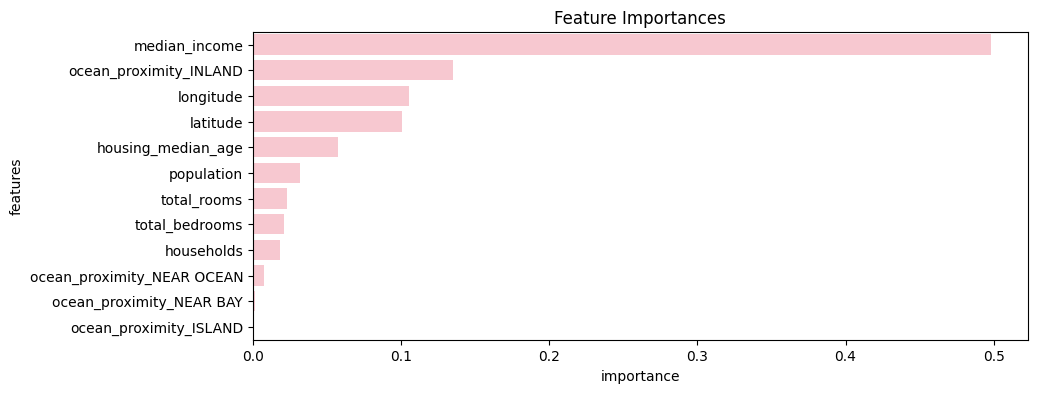

In [391]:
plt.figure(figsize=(10,4))
sns.barplot(data=df_importance, x='importance', y='features', color='pink')
plt.title('Feature Importances')
plt.show()

Dari features importance terlihat bahwa kolom yang paling berpengaruh terhadap pemodelan adalah kolom median income, sedangkan kolom housing_median_age menduduki peringkat ke 5, sehingga dapat diambil kesimpulan bahwa pemodelan pada tahun 2022 yang membutuhkan pengubahan pada kolom-kolom tersebut dapat dipertanggungjawabkan.

### **9. COST EVALUATION**

**Harga Aktual vs Prediksi**

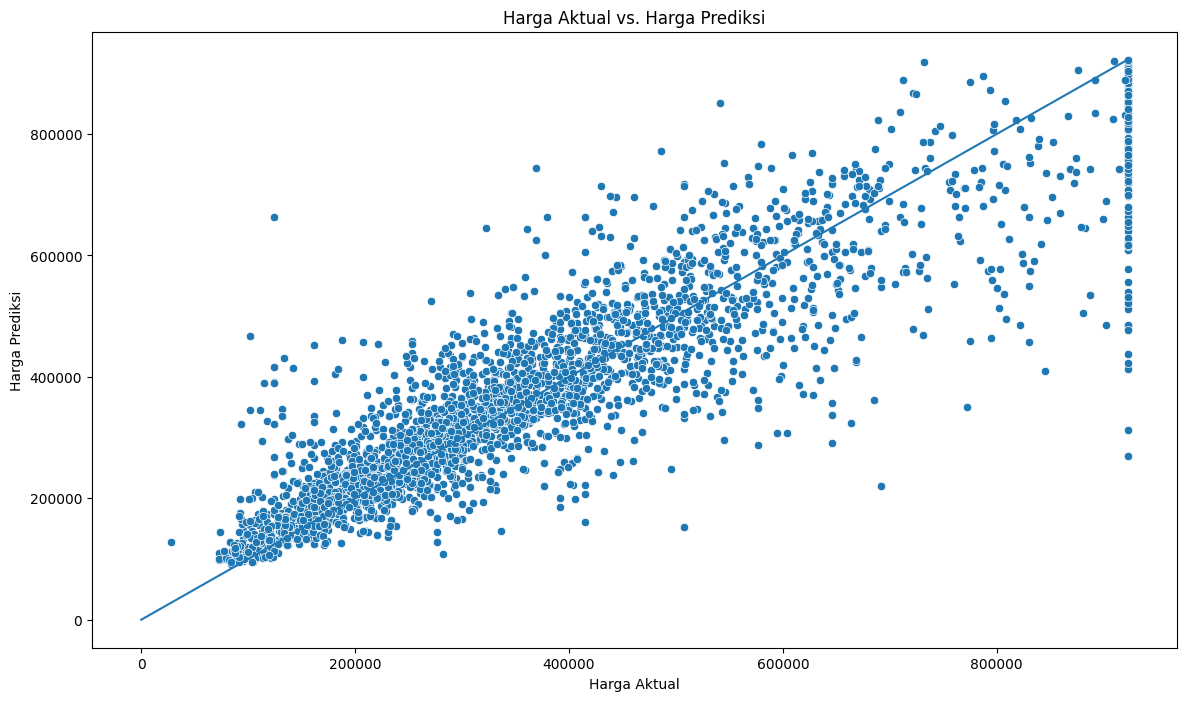

In [407]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test2022, y=y_pred_rf2022).set(title='Harga Aktual vs. Harga Prediksi', xlabel='Harga Aktual', ylabel='Harga Prediksi');

plt.plot([0, 920000], [0, 920000])

plt.show()

**Analisis**

Dari hasil plot diatas terlihat bahwa model sudah cukup baik dalam memprediksi harga rumah di California pada tahun 2022, namun saat harga rumah tepat menyentuh nilai di kisaran 920000 USD, model tidak dapat memprediksi dengan baik dikarenakan pada nilai tersebut target (y) yang digunakan untuk learning banyak berupa target (y) yang masuk ke dalam outliers. Oleh karena itu model ini bisa digunakan untuk memprediksi harga rumah di California pada tahun 2022 dengan nilai harga rumah dibawah 920000 USD.

### **10. MODEL LIMITATION**

Limitasi model ini adalah hanya berlaku untuk harga rumah di California pada tahun 2022 dengan nilai harga rumah dibawah 920000 USD.

### **11. CONCLUTION**

Berikut adalah beberapa kesimpulan yang dapat dirangkum :
- Ketika diprediksi ke test_set, model terbaik menghasilkan nilai rata-rata RMSE sebesar 92516, MAE sebesar 61292, dan rata-rata MAPE sebesar 18%. dimana nilai MAPE tersebut sama persis dengan nilai saat diuji ke train_set, hal ini menandakan bahwa model tidak mengalami overfitting karena nilai prediksi di train_set dan di test_set tidak berbeda signifikan.
- Outliers dari data memuat informasi cukup penting karena dapat meningkatkan performa model, walaupun tetap memiliki efek negatif dimana ketika model digunakan memprediksi target harga rumah yang masuk ke dalam outliers, model tidak mampu memprediksi dengan baik.
- Hyperparameter Tuning tidak menghasilkan model yang lebih baik daripada ketika model tidak di tuning( Nilai MAPE sebelum tuning : 18%, Nilai MAPE setelah tuning 1 : 24%, Nilai MAPE setelah tuning 2 : 21%), hal ini menunjukkan model dengan parameter yang tidak diatur tidak selalu menghasilkan model yang overfitting.
- Model dapat dimodifikasi untuk memprediksi harga rumah pada tahun tertentu dengan mengubah nilai target dan beberapa kolom fitur berdasarkan kepada persentase inflation_rates.
- Untuk pemodelan yang dibuat pada project ini, limitasi model berlaku untuk memprediksi harga rumah di California pada tahun 2022 dengan nilai harga rumah dibawah 920000 USD.

### **12. RECOMMENDATION**

- Pemerintah USA sudah bisa menggunakan model ini untuk memprediksi harga rumah di California pada tahun 2022 dengan rentang nilai error rata-rata 18 % dari nilai aktual, dan limitasi model nilai harga rumah dibawah 920000 USD.
- Performa model ini mungkin masih bisa ditingkatkan dengan melakukan handling outliers berdasarkan domain knowledge dengan memilah kolom mana yang perlu dihilangkan outliers (tidak semua kolom dihilangkan outliersnya).

### **13. SAVE & LOAD MODEL**

In [439]:
# saving model

# best model
# final_model = rf

# fitting to  all data
# final_model.fit(X_tahun2022, y_tahun2022)

# save
# pickle.dump(final_model, open('model_randomforest_capstone3_saladin.sav', 'wb'))

In [412]:
# load model
model_loaded_pickle = pickle.load(open('model_randomforest_capstone3_saladin.sav', 'rb'))

**Predict(to existing data)**

In [413]:
# predict data index ke-1
X_tahun2022.iloc[[0]]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-119.79,36.73,94.0,112.0,28.0,193.0,40.0,3.64348,1,0,0,0


In [423]:
# nilai aktual data index ke-1 adalah 184480
y_tahun2022.iloc[1]

184480.0

In [424]:
# prediction result untuk data index ke-1
model_loaded_pickle.predict(X_tahun2022.iloc[[1]])

# data index ke-1 diprediksi memiliki harga rumah sebesar 187225

array([187225.0624])

In [427]:
# persentase error hasil prediksi data index ke-1 1.4 %
(model_loaded_pickle.predict(X_tahun2022.iloc[[1]]) - y_tahun2022.iloc[1])/model_loaded_pickle.predict(X_tahun2022.iloc[[1]]) * 100

array([1.46618319])